In [1]:
import pandas as pd
from unidecode import unidecode
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


In [9]:
df = pd.read_csv('GrammarandProductReviews.csv')


# Mostrar las primeras filas del dataframe
print(df.head())



                     id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories             dateAdded  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...  2017-07-25T00:52:42Z   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   

            dateUpdated          ean  \
0  2018-02-05T08:36:58Z  6.02537E+11   
1  2018-02-05T11:27:45Z  73416000391   
2  2018-02-05T11:27:45Z  73416000391   
3  2018-02-05T11:25:51Z  67981934427   
4  2018-02-05T11:25:51Z  67981934427   

                         

In [10]:
# Eliminar duplicados
df.drop_duplicates(inplace=True)


In [7]:
# Ver columnas con valores nulos
print(df.isnull().sum())


id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews.date               67
reviews.dateAdded           0
reviews.dateSeen            0
reviews.didPurchase     38886
reviews.doRecommend     10615
reviews.id              38886
reviews.numHelpful      38536
reviews.rating              0
reviews.sourceURLs          0
reviews.text               36
reviews.title             477
reviews.userCity        65634
reviews.userProvince    70595
reviews.username          102
upc                         2
dtype: int64


In [11]:
# Eliminar columnas innecesarias
df.drop(columns=['manufacturerNumber', 'ean', 'upc', 'reviews.id', 'reviews.numHelpful', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.userCity', 'reviews.userProvince', 'reviews.sourceURLs', 'keys'], inplace=True)
# Puedes eliminar filas o columnas si los valores nulos son significativos
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# Ver columnas con valores nulos
print(df.isnull().sum())


id                     0
brand                  0
categories             0
dateAdded              0
dateUpdated            0
manufacturer         141
name                   0
reviews.date          67
reviews.dateAdded      0
reviews.dateSeen       0
reviews.rating         0
reviews.text           0
reviews.title        465
reviews.username     102
dtype: int64


In [12]:
nltk.download('stopwords')

# Cargar el conjunto de stopwords en inglés
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rentt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df['reviews.title'].describe

<bound method NDFrame.describe of 0                     Just Awesome
1                             Good
2                             Good
3                     Disappointed
4                       Irritation
                   ...            
71039           Solves the problem
71040                 Great stuff!
71041                    My review
71042            Wonderful Product
71043    Makes The Holidays Better
Name: reviews.title, Length: 71008, dtype: object>

In [36]:
train = df.copy()

train['reviews.username'] = train['reviews.username'].replace("An anonymous customer", "Anonymous")
train['reviews.username'] = train['reviews.username'].replace("ByAmazon Customer", "Anonymous")

# Convertir el texto a mayúsculas o a minúsculas
train['reviews.title'] = train['reviews.title'].str.lower()
train['reviews.text'] = train['reviews.text'].str.lower()

# Quitar los caracteres especiales que aparecen como "#","@" o los apóstrofes.
train['reviews.title'] = train['reviews.title'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
train['reviews.text'] = train['reviews.text'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)

# Quitar las url
train['reviews.text'] = train['reviews.text'].str.replace(r'http\S+|www.\S+', '', regex=True)
train['reviews.title'] = train['reviews.title'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Revisar si hay emoticones y quitarlos
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Aplicar eliminación de emojis
train['reviews.text'] = train['reviews.text'].apply(remove_emojis)

train['reviews.title'] = train['reviews.title'].astype(str)
train['reviews.title'] = train['reviews.title'].apply(remove_emojis)

# Quitar los signos de puntuación
train['reviews.text'] = train['reviews.text'].str.replace(r'[^\w\s]', '', regex=True)
train['reviews.title'] = train['reviews.title'].str.replace(r'[^\w\s]', '', regex=True)

# Quitar los artículos, preposiciones y conjunciones (stopwords)
train['reviews.text'] = train['reviews.text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
train['reviews.title'] = train['reviews.title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Quitar números si considera que interferirán en la clasificación
train['reviews.text'] = train['reviews.text'].str.replace(r'\b\d+\b', '', regex=True)
train['reviews.title'] = train['reviews.title'].str.replace(r'\b\d+\b', '', regex=True)

# Mostrar algunas filas para verificar
print(train[['reviews.title', 'reviews.text']].head())

print(train[['reviews.title', 'reviews.text']].describe())

  reviews.title                                       reviews.text
0       awesome  love album good hip hop side current pop sound...
1          good        good flavor review collected part promotion
2          good                                        good flavor
3  disappointed  read reviews looking buying one couples lubric...
4    irritation  husband bought gel us gel caused irritation fe...
       reviews.title reviews.text
count          71008        71008
unique         29307        64521
top      great movie         good
freq            2805           73


In [32]:
graph_data = train.copy()

def most_common_word(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    if len(words) > 0:
        return Counter(words).most_common(1)[0]  # Devuelve la palabra más común y su frecuencia
    else:
        return None

# Aplicar a la columna 'reviews.text'
graph_data['most_common_word'] = graph_data['reviews.text'].apply(most_common_word)

# Mostrar las primeras filas con la palabra más repetida
print(graph_data[['reviews.text', 'most_common_word']].head())


                                        reviews.text most_common_word
0  love album good hip hop side current pop sound...        (love, 1)
1        good flavor review collected part promotion        (good, 1)
2                                        good flavor        (good, 1)
3  read reviews looking buying one couples lubric...        (read, 2)
4  husband bought gel us gel caused irritation fe...         (gel, 3)


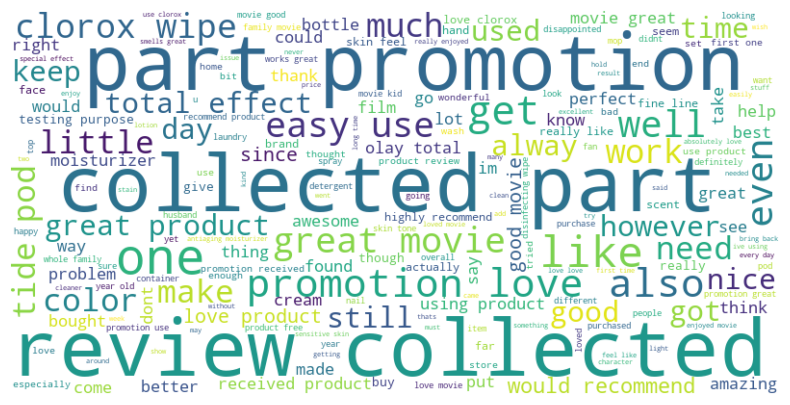

In [33]:
# Concatenar todas las reseñas en un solo texto
all_reviews = ' '.join(train['reviews.text'].dropna())

# Generar la nube de palabras
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(all_reviews)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


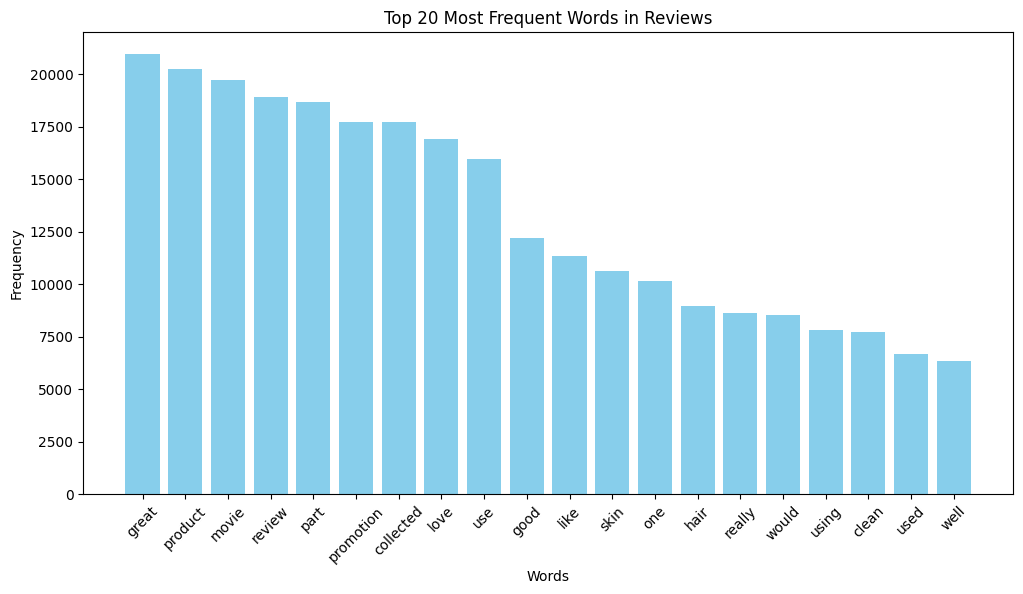

In [34]:
# Contar las palabras más frecuentes (excluyendo stopwords)
words = [word for review in train['reviews.text'] for word in review.split() if word not in stop_words]
word_counts = Counter(words)

# Convertir los conteos a un DataFrame para visualización
word_freq_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.bar(word_freq_df['Word'], word_freq_df['Frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in Reviews')
plt.xticks(rotation=45)
plt.show()


In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')

# Cargar las listas de palabras positivas y negativas de opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\rentt\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [42]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment_value(text):
    # Obtener el puntaje de sentimiento
    score = analyzer.polarity_scores(text)
    
    # Devolver el puntaje compuesto ('compound')
    return score['compound']

# Aplicar VADER a las reseñas para obtener el valor numérico
train['vader_sentiment_value'] = train['reviews.text'].apply(vader_sentiment_value)

# Mostrar los resultados con el valor de sentimiento
print(train[['reviews.text', 'vader_sentiment_value']].head())


                                        reviews.text  vader_sentiment_value
0  love album good hip hop side current pop sound...                 0.6908
1        good flavor review collected part promotion                 0.4404
2                                        good flavor                 0.4404
3  read reviews looking buying one couples lubric...                -0.7305
4  husband bought gel us gel caused irritation fe...                -0.4423


In [43]:
positive_reviews = train[train['vader_sentiment_value'] >= 0.05]
print(positive_reviews[['reviews.text', 'vader_sentiment_value']].head())

negative_reviews = train[train['vader_sentiment_value'] <= -0.05]
print(negative_reviews[['reviews.text', 'vader_sentiment_value']].head())

neutral_reviews = train[(train['vader_sentiment_value'] > -0.05) & (train['vader_sentiment_value'] < 0.05)]
print(neutral_reviews[['reviews.text', 'vader_sentiment_value']].head())


                                        reviews.text  vader_sentiment_value
0  love album good hip hop side current pop sound...                 0.6908
1        good flavor review collected part promotion                 0.4404
2                                        good flavor                 0.4404
5  boyfriend bought spice things bedroom highly d...                 0.2732
6  bought earlier today excited check based produ...                 0.2716
                                         reviews.text  vader_sentiment_value
3   read reviews looking buying one couples lubric...                -0.7305
4   husband bought gel us gel caused irritation fe...                -0.4423
8   husband bought extra fun werevboth extremely d...                -0.2643
16  bought product spice things fianc didnt anythi...                -0.3570
19  first time using ky didnt anything opinion fel...                -0.1531
                                         reviews.text  vader_sentiment_value
9   g

In [44]:
# Agrupar por nombre del producto y obtener el promedio de sentimiento
product_quality = train.groupby('name')['vader_sentiment_value'].mean().sort_values(ascending=False)

# Obtener los 10 productos con mejor reseña
top_10_best_quality_products = product_quality.head(10)
print(top_10_best_quality_products)


name
Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack)      0.98820
JNH Lifestyles Goldstar 3 Person FAR Infrared Sauna                                                     0.98440
Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12    0.98320
Bebe Au Lait174 Premium Muslin Nursing Scarf - Nightingale                                              0.97900
Elvis Presley - Girl Happy (cd)                                                                         0.97290
The Honest Company Bar Soap, Lavender                                                                   0.96115
Essex Pendulum Wall Clock Black - Timekeeper174                                                         0.96010
Healthy Skoop Organic Protein Powder - Chocolate - 15.9oz                                               0.95980
John Frieda Brilliant Brunette Colour Protecting Moisturising Conditioner, 20oz                    

In [45]:
# Obtener los 10 productos con peor reseña
top_10_worst_quality_products = product_quality.sort_values(ascending=True)
print(top_10_worst_quality_products.head(10))


name
Horizon174 Organic Unsalted Butter - 1lbs                                        -0.8020
Pocket Watch Wall Clock Distressed Black - Yosemite Home Decor174                -0.7783
Heinz Tomato Ketchup, 38oz                                                       -0.7003
Swann Door Alarm - White (swads-Alarmk-Gl)                                       -0.4996
Wallmount Server Cabinet (450mm, 9 RU)                                           -0.4939
Dauphine Traditional French Accent Coffee Table - Baxton Studio                  -0.4404
Ecotrin Pain Reliever Regular Strength 325mg Tablets - Aspirin (nsaid) - 300ct   -0.4019
Black Opal Total Coverage Spot & Scar Eraser, Hazelnut                           -0.3612
High-Dome Floor Door Stop                                                        -0.3182
Peak Long Life Antifreeze Coolant 1-Gal.                                         -0.3089
Name: vader_sentiment_value, dtype: float64


In [46]:
# Contar cuántas reseñas ha dado cada usuario
top_reviewers = train['reviews.username'].value_counts().head(10)
print(top_reviewers)


reviews.username
Anonymous    592
Mike         105
Chris         88
Dave          57
John          49
Rick          41
James         32
Robert        31
Sandy         30
Tony          29
Name: count, dtype: int64


In [47]:
top_positive_reviewers = positive_reviews.groupby('reviews.username').size().sort_values(ascending=False).head(10)
print(top_positive_reviewers)


reviews.username
Anonymous    498
Mike         100
Chris         79
Dave          54
John          44
Rick          34
James         29
Robert        28
Sandy         26
Tony          25
dtype: int64


In [48]:
top_positive_reviewers = positive_reviews.groupby('reviews.username').size().sort_values(ascending=False).head(10)
print("Positive Reviewers")
print(top_positive_reviewers)

top_negative_reviewers = negative_reviews.groupby('reviews.username').size().sort_values(ascending=False).head(10)
print("\n\nNegative Reviewers")
print(top_negative_reviewers)


Positive Reviewers
reviews.username
Anonymous    498
Mike         100
Chris         79
Dave          54
John          44
Rick          34
James         29
Robert        28
Sandy         26
Tony          25
dtype: int64


Negative Reviewers
reviews.username
Anonymous    57
Lisa          4
Mike          4
Chris         4
Nancy         3
Rick          3
Rich          3
Bobcat        3
Moochie       3
Vicky         3
dtype: int64


In [49]:
# Agrupar por productor (manufacturer) y obtener el promedio de sentimiento
producer_quality = train.groupby('manufacturer')['vader_sentiment_value'].mean().sort_values(ascending=False)

# Obtener los 10 productores con productos de mejor calidad
top_10_best_producers = producer_quality.head(10)
print(top_10_best_producers)


manufacturer
Avery                        0.9882
JNH Lifestyles               0.9844
Carson-Dellosa Publishing    0.9832
Bebe au Lait                 0.9790
SBME SPECIAL MKTS.           0.9729
Timekeeper                   0.9601
SKOOP LLC                    0.9598
John Frieda                  0.9572
Baby Jogger                  0.9490
KINO                         0.9417
Name: vader_sentiment_value, dtype: float64


In [51]:
# Obtener los 10 productores con productos de peor calidad
top_10_worst_producers = producer_quality.sort_values(ascending=True)
print(top_10_worst_producers.head(10))


manufacturer
Horizon Organic             -0.8020
Yosemite Home Decor         -0.7783
Heinz North America         -0.7003
Swann Communications USA    -0.4996
iStarUSA                    -0.4939
Ecotrin                     -0.4019
Biocosmetic Research Labs   -0.3612
Stanley Hardware            -0.3182
Peak                        -0.3089
TRADEMARK GAMES  INC        -0.0572
Name: vader_sentiment_value, dtype: float64
